<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/project_demo_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.optim import *
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import math
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

class_counts = torch.zeros(10, dtype=torch.int32)

for (images, labels) in trainloader:
  for label in labels:
    class_counts[label] += 1

assert class_counts.sum()==60000

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def softmax_temperature(logits, temperature=0.00001):
  pro = F.softmax(logits / temperature, dim=-1)
  # pro = torch.matmul(pro, torch.FloatTensor(range(0, pro.shape[1])));
  return pro;
  # return one_hot_code

In [5]:
class LUTModelWithAnnealTemperature(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LUTModelWithAnnealTemperature, self).__init__()
        self.emb = nn.Embedding(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x, temperature):
        # out = self.fc1(x)
        # out = F.relu(out)
        if self.training:
          # print(x.shape)
          # print(self.emb.weight.shape)
          out = softmax_temperature(x, temperature)
          out = out @ self.emb.weight
        else:
          out = softmax_temperature(x, temperature)
          # out = mapping_onehot_vector(out).round().long()
          # out = self.emb(out)

          nozero = torch.nonzero(out);
          # print(np.array(nozero).shape[1])
          for i in range(out.shape[0]):
            idx = torch.where(nozero[:,0]==i)[0]
            rows = nozero[idx, 1].long()
            out[i] = torch.mean(self.emb(rows), axis=0)
          
        # out = self.emb(out.long())
        # out = self.emb(out)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [24]:
# build the model 
Annealing_lut_model = LUTModelWithAnnealTemperature(784, 784, 10).to(device)
Annealing_lut_model.train()
# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-2  #Learning rate
Annealing_lut_optimiser = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(Annealing_lut_optimiser,milestones=[2500],gamma = 0.2)
Loss_Annealing_Model_exp = []
# the epoch loop
i = 0;
for epoch in range(50):
    running_loss = 0.0
    print("Epoch %d, lr %4.5f" % (epoch, Annealing_lut_optimiser.state_dict()['param_groups'][0]['lr']))
    for data in trainloader:
        # get the inputs
        i = i+1
        inputs, labels = data

        # zero the parameter gradients
        Annealing_lut_optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        outputs = Annealing_lut_model(inputs.to(device), max(0.0001, math.exp(-15 * math.pow(10, -5) * (i))))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        Annealing_lut_optimiser.step()
        scheduler.step()
        # print(optimiser.param_groups[0]['params'][2])
        # print(np.all(optimiser.param_groups[0]['params'][0].grad.numpy() == 0))
        # keep track of the loss this epoch
        running_loss += loss.item()
        # break
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    print("Epoch %d, temperature %4.8f" % (epoch, max(0.0001, math.exp(-20 * math.pow(10, -5) * (i)))))
    Loss_Annealing_Model_exp.append(running_loss)
print('**** Finished Training ****')

Epoch 0, lr 0.01000
Epoch 0, loss 288.35
Epoch 0, temperature 0.91046484
Epoch 1, lr 0.01000
Epoch 1, loss 151.68
Epoch 1, temperature 0.82894622
Epoch 2, lr 0.01000
Epoch 2, loss 121.48
Epoch 2, temperature 0.75472638
Epoch 3, lr 0.01000
Epoch 3, loss 95.30
Epoch 3, temperature 0.68715183
Epoch 4, lr 0.01000
Epoch 4, loss 74.72
Epoch 4, temperature 0.62562758
Epoch 5, lr 0.01000
Epoch 5, loss 56.69
Epoch 5, temperature 0.56961192
Epoch 6, lr 0.00200
Epoch 6, loss 49.17
Epoch 6, temperature 0.51861162
Epoch 7, lr 0.00200
Epoch 7, loss 45.50
Epoch 7, temperature 0.47217764
Epoch 8, lr 0.00200
Epoch 8, loss 41.67
Epoch 8, temperature 0.42990114
Epoch 9, lr 0.00200
Epoch 9, loss 38.51
Epoch 9, temperature 0.39140987
Epoch 10, lr 0.00200
Epoch 10, loss 35.05
Epoch 10, temperature 0.35636493
Epoch 11, lr 0.00200
Epoch 11, loss 31.75
Epoch 11, temperature 0.32445773
Epoch 12, lr 0.00200
Epoch 12, loss 28.47
Epoch 12, temperature 0.29540736
Epoch 13, lr 0.00200
Epoch 13, loss 25.57
Epoch 13, 

In [16]:
# build the model 
Annealing_lut_model = LUTModelWithAnnealTemperature(784, 784, 10).to(device)
Annealing_lut_model.train()
# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-2  #Learning rate
Annealing_lut_optimiser = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(Annealing_lut_optimiser,milestones=[2500],gamma = 0.2)
Loss_Annealing_Model_Prop = []
# the epoch loop
i = 0;
for epoch in range(50):
    running_loss = 0.0
    print("Epoch %d, lr %4.5f" % (epoch, Annealing_lut_optimiser.state_dict()['param_groups'][0]['lr']))
    for data in trainloader:
        # get the inputs
        i = i+1
        inputs, labels = data

        # zero the parameter gradients
        Annealing_lut_optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        outputs = Annealing_lut_model(inputs.to(device), max(0.0001, math.pow(0.9998, i)))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        Annealing_lut_optimiser.step()
        scheduler.step()
        # print(optimiser.param_groups[0]['params'][2])
        # print(np.all(optimiser.param_groups[0]['params'][0].grad.numpy() == 0))
        # keep track of the loss this epoch
        running_loss += loss.item()
        # break
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    print("Epoch %d, temperature %4.8f" % (epoch, max(0.0001, math.pow(0.9998, i))))
    Loss_Annealing_Model_Prop.append(running_loss)
print('**** Finished Training ****')

Epoch 0, lr 0.01000
Epoch 0, loss 289.73
Epoch 0, temperature 0.91045630
Epoch 1, lr 0.01000
Epoch 1, loss 148.18
Epoch 1, temperature 0.82893067
Epoch 2, lr 0.01000
Epoch 2, loss 117.44
Epoch 2, temperature 0.75470514
Epoch 3, lr 0.01000
Epoch 3, loss 88.51
Epoch 3, temperature 0.68712605
Epoch 4, lr 0.01000
Epoch 4, loss 67.89
Epoch 4, temperature 0.62559824
Epoch 5, lr 0.01000
Epoch 5, loss 50.80
Epoch 5, temperature 0.56957985
Epoch 6, lr 0.00200
Epoch 6, loss 42.40
Epoch 6, temperature 0.51857756
Epoch 7, lr 0.00200
Epoch 7, loss 38.62
Epoch 7, temperature 0.47214221
Epoch 8, lr 0.00200
Epoch 8, loss 35.04
Epoch 8, temperature 0.42986485
Epoch 9, lr 0.00200
Epoch 9, loss 31.64
Epoch 9, temperature 0.39137316
Epoch 10, lr 0.00200
Epoch 10, loss 28.34
Epoch 10, temperature 0.35632815
Epoch 11, lr 0.00200
Epoch 11, loss 25.15
Epoch 11, temperature 0.32442121
Epoch 12, lr 0.00200
Epoch 12, loss 22.05
Epoch 12, temperature 0.29537133
Epoch 13, lr 0.00200
Epoch 13, loss 19.13
Epoch 13, 

In [43]:
# build the model 
Annealing_lut_model = LUTModelWithAnnealTemperature(784, 784, 10).to(device)
Annealing_lut_model.train()
# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-2  #Learning rate
Annealing_lut_optimiser = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(Annealing_lut_optimiser,milestones=[1500],gamma = 0.2)
Loss_Annealing_Model_linear = []
# the epoch loop
i = 0;
for epoch in range(50):
    running_loss = 0.0
    print("Epoch %d, lr %4.5f" % (epoch, Annealing_lut_optimiser.state_dict()['param_groups'][0]['lr']))
    for data in trainloader:
        # get the inputs
        i = i+1
        inputs, labels = data

        # zero the parameter gradients
        Annealing_lut_optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        outputs = Annealing_lut_model(inputs.to(device), max(0.0001, 0.9999 - 0.021*epoch))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        Annealing_lut_optimiser.step()
        scheduler.step()
        # print(optimiser.param_groups[0]['params'][2])
        # print(np.all(optimiser.param_groups[0]['params'][0].grad.numpy() == 0))
        # keep track of the loss this epoch
        running_loss += loss.item()
        # break
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    print("Epoch %d, temperature %4.8f" % (epoch, max(0.0001, 0.9999 - 0.02*epoch)))
    Loss_Annealing_Model_linear.append(running_loss)
print('**** Finished Training ****')

Epoch 0, lr 0.01000
Epoch 0, loss 299.75
Epoch 0, temperature 0.99990000
Epoch 1, lr 0.01000
Epoch 1, loss 155.83
Epoch 1, temperature 0.97990000
Epoch 2, lr 0.01000
Epoch 2, loss 129.39
Epoch 2, temperature 0.95990000
Epoch 3, lr 0.01000
Epoch 3, loss 104.30
Epoch 3, temperature 0.93990000
Epoch 4, lr 0.00200
Epoch 4, loss 95.75
Epoch 4, temperature 0.91990000
Epoch 5, lr 0.00200
Epoch 5, loss 90.40
Epoch 5, temperature 0.89990000
Epoch 6, lr 0.00200
Epoch 6, loss 85.30
Epoch 6, temperature 0.87990000
Epoch 7, lr 0.00200
Epoch 7, loss 80.32
Epoch 7, temperature 0.85990000
Epoch 8, lr 0.00200
Epoch 8, loss 75.45
Epoch 8, temperature 0.83990000
Epoch 9, lr 0.00200
Epoch 9, loss 70.50
Epoch 9, temperature 0.81990000
Epoch 10, lr 0.00200
Epoch 10, loss 66.45
Epoch 10, temperature 0.79990000
Epoch 11, lr 0.00200
Epoch 11, loss 62.06
Epoch 11, temperature 0.77990000
Epoch 12, lr 0.00200
Epoch 12, loss 58.32
Epoch 12, temperature 0.75990000
Epoch 13, lr 0.00200
Epoch 13, loss 54.78
Epoch 13,

In [15]:
print(i)

23450


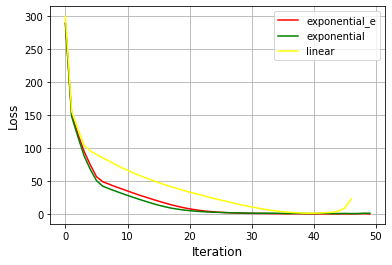

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Loss_Annealing_Model_exp, Color='red', label='exponential_e')
ax.plot(Loss_Annealing_Model_Prop, Color='green', label='exponential')
ax.plot(Loss_Annealing_Model_linear[:47], Color='yellow', label='linear')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()